In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import os

## Get temp data, from rainshelter

In [2]:
AllData=pd.read_csv('K:\Rainshelter\Oats 2017-2018\LoggedData\RainShelterBeta_Energy.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')
TempData = AllData.ix['2017-10-04':,'AirTC_Avg'].resample('D').mean().cumsum()

## Get Layout file

In [3]:
Layout = pd.read_excel('K:\CPDiary\Data\BaxtersMVI\TrialLayout.xlsx',index_col='Plot')
NDVIPlotMaping = pd.read_excel('K:\CPDiary\Data\BaxtersMVI\TrialLayout.xlsx',index_col='NDVISample#')

## Get NDVI raw data

In [4]:
GSFiles = []
mydir = 'K:\CPDiary\Data\BaxtersMVI\Greenseeker data\GS data files'
for File in os.listdir(mydir):
    if File.endswith('.txt'):
        if ('Avg' not in File) & ('Diag' not in File) :
            GSFiles.append(os.path.join(mydir, File))

In [5]:
GSFiles

['K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\01-04-2018_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\01-08-2018_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\10-12-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\10-17-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\10-24-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\10-31-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\11-07-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\11-14-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\11-20-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\11-28-2017_BaxtersMVI.txt',
 'K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data f

## Apply experiment design index to NDVI data

In [6]:
#Set up blank dataframe to take data
ColumnLables = ['Time(ms)','SampleNumber','Count','NDVI','VI_2','REDrefc','NIRrefc','Plot','Zone','Rep','Irrig','Date']
TabIndex = pd.MultiIndex.from_arrays([[],[],[],[]],names=['Date','Zone','Irrig','Rep'])
NDVIData = pd.DataFrame(columns=ColumnLables[2:],index = TabIndex)
ObsDates = []
#Read each file
for ObsTable in GSFiles:
    #Read in file and find which lines have legit data
    DateString = ObsTable.strip('.txt').strip('K:\\CPDiary\\Data\\BaxtersMVI\\Greenseeker data\\GS data files\\').strip('BaxtersMVI').strip('_')
    ObsDate = pd.to_datetime(DateString,format = '%m-%d-%Y')
    ObsDates.append(ObsDate)
    DataTab = pd.read_csv(ObsTable,skiprows = [0],header=None)
    DataTab.columns = ColumnLables[0:7]
    DataTab.dropna(inplace=True)
    DataTab.drop('Time(ms)',axis=1,inplace=True)
    DataTab.ix[:,'Plot'] = [NDVIPlotMaping.ix[DataTab.ix[x,'SampleNumber'],'Plot'] for x in DataTab.index]
    DataTab.ix[:,'Zone'] = [Layout.ix[DataTab.ix[x,'Plot'],'Zone'] for x in DataTab.index]
    DataTab.ix[:,'Rep'] = [Layout.ix[DataTab.ix[x,'Plot'],'Rep'] for x in DataTab.index]
    DataTab.ix[:,'Irrig'] = [Layout.ix[DataTab.ix[x,'Plot'],'Irrig'] for x in DataTab.index]
    DataTab.ix[:,'Date'] = ObsDate
    DataTab.set_index(['Date','Zone','Irrig','Rep'],inplace=True,drop=False)
    NDVIData = NDVIData.append(DataTab)
NDVIData.sort_index(inplace=True)
ObsDates.sort()

## Estimate fPAR from NDVI using the scaling method

In [7]:
NDVIMeans = NDVIData.groupby(level = ['Date','Zone','Irrig','Rep']).mean()
CropNDVI  = NDVIMeans.ix[~NDVIMeans.index.isin(['Bare'],level=2),'NDVI']
BareNDVI = NDVIMeans.ix[NDVIMeans.index.isin(['Bare'],level=2),'NDVI']
fPARndvi = pd.DataFrame(index = CropNDVI.index, columns=['est'])
for Date in ObsDates:
    BareVal = 0.15
    if BareNDVI[Date].values != np.nan:
        BareVal = BareNDVI[Date].values
    fPARndvi.ix[Date,'est'] = np.subtract(CropNDVI.ix[Date].values, BareVal)/np.subtract(0.95,BareVal)
fPARndvi.ix[:,'est'] = pd.to_numeric(fPARndvi.ix[:,'est']) 
fPARndvi.index  =fPARndvi.index.swaplevel('Date','Zone',)
fPARndvi.index  =fPARndvi.index.swaplevel('Date','Irrig',)
fPARndvi.index  =fPARndvi.index.swaplevel('Date','Rep',)
fPARndvi.ix[:,'AccumTemp'] = [TempData.ix[x] for x in fPARndvi.index.get_level_values(3)]
fPARTreatMeans = fPARndvi.groupby(level = ['Zone','Irrig','Date']).mean()
#fPARTreatMeans.ix[:,'AccumTemp'] = [TempData.ix[x[2]] for x in fPARTreatMeans.index]

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\kernelbase.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


## Interpolate estimated fPAR out to daily values

In [8]:
Start = ObsDates[0]
Today = ObsDates[-1]
DailyDates = pd.date_range(Start,Today)
TreatIndex = fPARndvi.groupby(level=['Zone','Irrig']).mean().index
DailyfPARMeans = pd.DataFrame(index = DailyDates, columns = TreatIndex)
for Treat in DailyfPARMeans.columns:
    DailyfPARMeans.ix[:,Treat] = np.interp(TempData.ix[Start:Today],fPARTreatMeans.ix[Treat,'AccumTemp'],fPARTreatMeans.ix[Treat,'est'])

In [9]:
Start = ObsDates[0]
Today = ObsDates[-1]
DailyDates = pd.date_range(Start,Today)
TreatIndex = fPARndvi.groupby(level=['Zone','Irrig','Rep']).mean().index
DailyfPAR = pd.DataFrame(index = DailyDates, columns =TreatIndex)
for plot in DailyfPAR.columns:
    DailyfPAR.ix[:,plot] = np.interp(TempData.ix[Start:Today],fPARndvi.ix[plot,'AccumTemp'],fPARndvi.ix[plot,'est'])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


## Make a graph to ensure all looks good

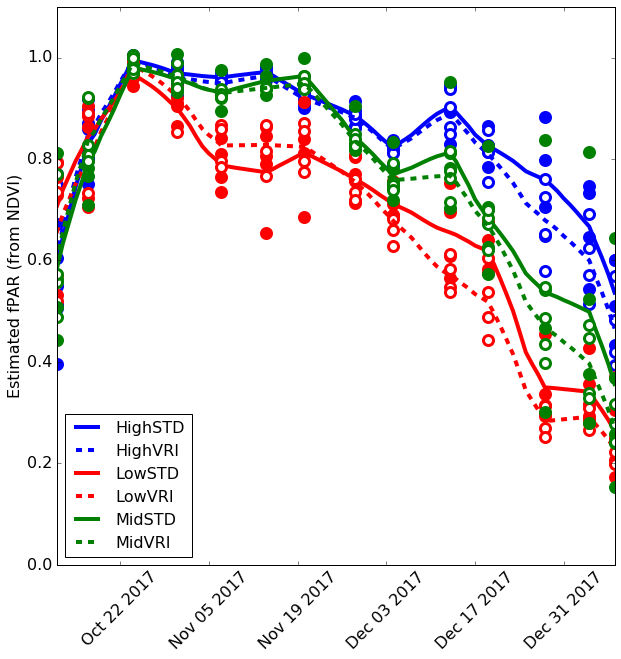

In [10]:
NDVIGraph = plt.figure(figsize=(10,10))
Irrigs = ['STD', 'VRI',] 
fills = ['b','w','r','w','g','w']
lines = ['-','--','-','--','-','--']
Zones = ['High', 'Low', 'Mid']
edges = ['b','b','r','r','g','g']
Reps = [1.0, 2.0, 3.0, 4.0]
pos = -1
for Zone in Zones:
    for Irrig in Irrigs:
        pos+=1
        for Rep in Reps:
            Plot = fPARndvi.ix[(Zone,Irrig,Rep),:]
            plt.plot(Plot.index,Plot.est,'o',mec=edges[pos],mfc=fills[pos],ms=10,mew=3,label='_nolegend_')
        plt.plot(DailyfPARMeans.index,DailyfPARMeans.ix[:,(Zone,Irrig)],lines[pos],color=edges[pos],label=Zone+Irrig,lw=4)
plt.ylabel('Estimated fPAR (from NDVI)',fontsize=16)
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.ylim(0,1.1)
plt.legend(loc=3,fontsize=16)


## Calculate surface albedo

In [11]:
def EstAlbedo(FPAR,coeff):
    _return = np.multiply(FPAR,coeff)
    _return = np.exp(_return)
    _return = np.multiply(_return,0.15)
    return _return

In [12]:
Albedo = pd.DataFrame(index = DailyfPAR.index,columns=DailyfPAR.columns)
for plot in Albedo.columns:
    Albedo.loc[:,plot] = [EstAlbedo(DailyfPAR.loc[x,plot],0.55) for x in DailyfPAR.index]

(0, 0.35)

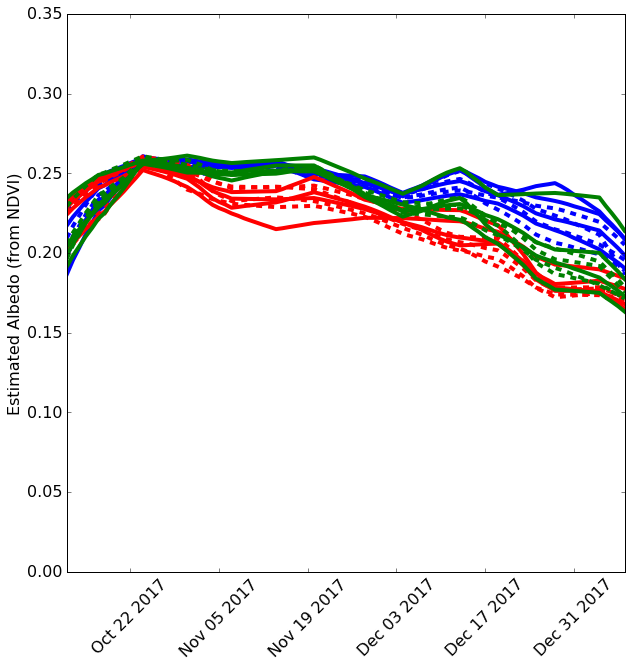

In [13]:
AlbedoGraph = plt.figure(figsize=(10,10))
Irrigs = ['STD', 'VRI',] 
fills = ['b','w','r','w','g','w']
lines = ['-','--','-','--','-','--']
Zones = ['High', 'Low', 'Mid']
edges = ['b','b','r','r','g','g']
Reps = [1.0, 2.0, 3.0, 4.0]
pos = -1
for Zone in Zones:
    for Irrig in Irrigs:
        pos+=1
        plt.plot(Albedo.index,Albedo.ix[:,(Zone,Irrig)],lines[pos],color=edges[pos],label=Zone+Irrig,lw=4)
plt.ylabel('Estimated Albedo (from NDVI)',fontsize=16)
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.ylim(0,0.35)
#plt.legend(loc=2,fontsize=16)

## export estimated fPAR for use in water use estimations

In [14]:
DailyfPAR.to_pickle('fPAR.pkl')
Albedo.to_pickle('Albedo.pkl')